## Demo: SingleRun with HasDelayPlugin
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This example notebook shows how you can integrate percentual delays in your simulation. We demonstrate how you can use the HasDelayPlugin, and how you can give it a certain delay percentage.

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugins
import opentnsim.core
import functools
import scipy.optimize

# TO DO


# See chat for power to velocity
# insert acceleration with power2v function. Better implementation for calculate power
# One notebook for calculating velocity depending on a set power. From 0 to end. Need to know resistance over time for increasing velocity.
# Depth integration. Varying depth over the graph -> see M v koningsveld. Might connect with opentnsim. move function -> velocity will be connected together.

# 0.1 Table of Contents

In [2]:
# 1. Determination of Power based on set speed of the vessel by means of Holtrop Mennen
# 2. Define Object Classes
# 3. Create Object and set your vessel properties including the set speed
# 4. Show results in numerical form
# 5. Show results in form of dataframe
# 6. Determination of Velocity based on set Power of the vessel by means of Holtrop Mennen
# 7. Detemrination of acceleration and deceleration.

# 1. Determine P based on V

In [3]:
#pip list
# https://www.dredgepoint.org/dredging-database/equipment/ham-318 (L_wl = 159)

In [4]:
def calculate_power(V_0=10, h=70,
                    L_wl=159, B=32, T = 13.55, T_e=5.9, T_Fe = 3.29, T_Ff = 13.64, T_F = 13.55,
                    nu=0.000001, C_b=0.85, rho=1025,
                    c_stern = 0, one_k2=2.5, g=9.81, P_inst = 28636, P_max = 28064, V_max_e = 12, V_max_f = 10, BB = 'yes'):
    
    
    #########################################################################################################################
    
    
    
    """1) Frictional resistance
            - 1st resistance component defined by Holtrop and Mennen (1982)
            - A modification to the original friction line is applied, based on literature of Zeng (2018), to account for shallow water effects """
    C_M = 1.006 - 0.0056 * C_b ** (-3.56)  # Midship section coefficient: ratio of actual area of immersed portion of the 
#                                            ships midship section to the porduct of wdht and draft.
    C_wp = (1 + 2 * C_b) / 3  # Waterplane coefficient : ratio of the actual area of the waterplane 
#                               to the product of the length and breadth of ship.
    C_p = C_b / C_M  # Prismatic coefficient: ratio of volume of displacement of a ship to that of a prism
#                       equal to lentg to tge distance between perpendicualrs of the ship and in cross-section of that of th immersed midship section.
    C_BB = 0.2 #coefficient related to the width of the bulbous bow and the width of the ship.
    
    
    # Block coefficient Cb = ratio underwater volume of ship to volume of recatngle having same overall length, breadth and depth.
    delta = C_b * L_wl * B * T  # Water displacement

    lcb = -13.5 + 19.4 * C_p  # longitudinal center of buoyancy
    L_R = L_wl * (1 - C_p + (0.06 * C_p * lcb) / (
                4 * C_p - 1))  # parameter reflecting the length of the run

    A_T = 0.2 * B * T  # transverse area of the transom
    
    if BB == "yes":
        A_BT = C_BB * B * T * C_M # transverse area of the bulb
    else:
        A_BT = 0
   
    # Total wet area
    S_T = L_wl * (2 * T + B) * np.sqrt(C_M) * (
                0.453 + 0.4425 * C_b - 0.2862 * C_M - 0.003467 * (
                    B / T) + 0.3696 * C_wp) + 2.38 * (A_BT / C_b)

    S_APP = 0.1 * S_T  # Wet area of appendages
    S_B = L_wl * B  # Area of flat bottom

    D_s = 0.7 * T  # Diameter of the screw


    R_e = V_0 * L_wl / nu  # Reynolds number
    D = h - T  # distance from bottom ship to the bottom of the fairway

    # Friction coefficient in deep water
    Cf_0 = 0.075 / ((np.log10(R_e) - 2) ** 2)

    # Friction coefficient proposed, taking into account shallow water effects
    Cf_proposed = (0.08169 / ((np.log10(R_e) - 1.717) ** 2)) * (
                1 + (0.003998 / (np.log10(R_e) - 4.393)) * (D / L_wl) ** (-1.083))

    # 'a' is the coefficient needed to calculate the Katsui friction coefficient
    a = 0.042612 * np.log10(R_e) + 0.56725
    Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762) ** a)

    # The average velocity underneath the ship, taking into account the shallow water effect

    if h / T <= 4:
        V_B = 0.4277 * V_0 * np.exp((h / T) ** (-0.07625))
    else:
        V_B = V_0

    # cf_proposed cannot be applied directly, since a vessel also has non-horizontal wet surfaces that have to be taken
    # into account. Therefore, the following formula for the final friction coefficient 'C_f' is defined:
    C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0) ** 2

    # The total frictional resistance R_f [kN]:
    R_f = (C_f * 0.5 * rho * (V_0 ** 2) * S_T) / 1000

    ########################################################################################################################

    """2) Viscous resistance
    - 2nd resistance component defined by Holtrop and Mennen (1982)
    - Form factor (1 + k1) has to be multiplied by the frictional resistance R_f, to account for the effect of viscosity"""

    # c_14 accounts for the specific shape of the afterbody
    c_14 = 1 + 0.0011 * c_stern

    # the form factor (1+k1) describes the viscous resistance
    one_k1 = 0.93 + 0.487118 * c_14 * ((B / L_wl) ** 1.06806) * ((T / L_wl) ** 0.46106) * (
                (L_wl / L_R) ** 0.121563) * (((L_wl ** 3) / delta) ** 0.36486) * (
                              (1 - C_p) ** (-0.60247))

    ########################################################################################################################


    """3) Appendage resistance
    - 3rd resistance component defined by Holtrop and Mennen (1982)
    - Appendages (like a rudder, shafts, skeg) result in additional frictional resistance"""

    # Frictional resistance resulting from wetted area of appendages: R_APP [kN]
    R_APP = (0.5 * rho * (V_0 ** 2) * S_APP * one_k2 * C_f) / 1000

    #################################################################################################################


    """Intermediate calculation: Karpov
    - The Karpov method computes a velocity correction that accounts for limited water depth (corrected velocity V2)
    - V2 has to be implemented in the wave resistance and the residual resistance terms"""

    # The Froude number used in the Karpov method is the depth related froude number F_nh

    # The different alpha** curves are determined with a sixth power polynomial approximation in Excel
    # A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve
    F_nh = V_0 / np.sqrt(g * h)

    if F_nh <= 0.4:

        if 0 <= h / T < 1.75:
            alpha_xx = (-4 * 10 ** (
                -12)) * F_nh ** 3 - 0.2143 * F_nh ** 2 - 0.0643 * F_nh + 0.9997
        if 1.75 <= h / T < 2.25:
            alpha_xx = -0.8333 * F_nh ** 3 + 0.25 * F_nh ** 2 - 0.0167 * F_nh + 1
        if 2.25 <= h / T < 2.75:
            alpha_xx = -1.25 * F_nh ** 4 + 0.5833 * F_nh ** 3 - 0.0375 * F_nh ** 2 - 0.0108 * F_nh + 1
        if h / T >= 2.75:
            alpha_xx = 1

    if F_nh > 0.4:
        if 0 <= h / T < 1.75:
            alpha_xx = -0.9274 * F_nh ** 6 + 9.5953 * F_nh ** 5 - 37.197 * F_nh ** 4 + 69.666 * F_nh ** 3 - 65.391 * F_nh ** 2 + 28.025 * F_nh - 3.4143
        if 1.75 <= h / T < 2.25:
            alpha_xx = 2.2152 * F_nh ** 6 - 11.852 * F_nh ** 5 + 21.499 * F_nh ** 4 - 12.174 * F_nh ** 3 - 4.7873 * F_nh ** 2 + 5.8662 * F_nh - 0.2652
        if 2.25 <= h / T < 2.75:
            alpha_xx = 1.2205 * F_nh ** 6 - 5.4999 * F_nh ** 5 + 5.7966 * F_nh ** 4 + 6.6491 * F_nh ** 3 - 16.123 * F_nh ** 2 + 9.2016 * F_nh - 0.6342
        if 2.75 <= h / T < 3.25:
            alpha_xx = -0.4085 * F_nh ** 6 + 4.534 * F_nh ** 5 - 18.443 * F_nh ** 4 + 35.744 * F_nh ** 3 - 34.381 * F_nh ** 2 + 15.042 * F_nh - 1.3807
        if 3.25 <= h / T < 3.75:
            alpha_xx = 0.4078 * F_nh ** 6 - 0.919 * F_nh ** 5 - 3.8292 * F_nh ** 4 + 15.738 * F_nh ** 3 - 19.766 * F_nh ** 2 + 9.7466 * F_nh - 0.6409
        if 3.75 <= h / T < 4.5:
            alpha_xx = 0.3067 * F_nh ** 6 - 0.3404 * F_nh ** 5 - 5.0511 * F_nh ** 4 + 16.892 * F_nh ** 3 - 20.265 * F_nh ** 2 + 9.9002 * F_nh - 0.6712
        if 4.5 <= h / T < 5.5:
            alpha_xx = 0.3212 * F_nh ** 6 - 0.3559 * F_nh ** 5 - 5.1056 * F_nh ** 4 + 16.926 * F_nh ** 3 - 20.253 * F_nh ** 2 + 10.013 * F_nh - 0.7196
        if 5.5 <= h / T < 6.5:
            alpha_xx = 0.9252 * F_nh ** 6 - 4.2574 * F_nh ** 5 + 5.0363 * F_nh ** 4 + 3.3282 * F_nh ** 3 - 10.367 * F_nh ** 2 + 6.3993 * F_nh - 0.2074
        if 6.5 <= h / T < 7.5:
            alpha_xx = 0.8442 * F_nh ** 6 - 4.0261 * F_nh ** 5 + 5.313 * F_nh ** 4 + 1.6442 * F_nh ** 3 - 8.1848 * F_nh ** 2 + 5.3209 * F_nh - 0.0267
        if 7.5 <= h / T < 8.5:
            alpha_xx = 0.1211 * F_nh ** 6 + 0.628 * F_nh ** 5 - 6.5106 * F_nh ** 4 + 16.7 * F_nh ** 3 - 18.267 * F_nh ** 2 + 8.7077 * F_nh - 0.4745

        if 8.5 <= h / T < 9.5:
            if F_nh < 0.6:
                alpha_xx = 1
            if F_nh >= 0.6:
                alpha_xx = -6.4069 * F_nh ** 6 + 47.308 * F_nh ** 5 - 141.93 * F_nh ** 4 + 220.23 * F_nh ** 3 - 185.05 * F_nh ** 2 + 79.25 * F_nh - 12.484
        if h / T >= 9.5:
            if F_nh < 0.6:
                alpha_xx = 1
            if F_nh >= 0.6:
                alpha_xx = -6.0727 * F_nh ** 6 + 44.97 * F_nh ** 5 - 135.21 * F_nh ** 4 + 210.13 * F_nh ** 3 - 176.72 * F_nh ** 2 + 75.728 * F_nh - 11.893

    V_2 = V_0 / alpha_xx

    #################################################################################################################


#     """4) Wave resistance
#     - 4th resistance component defined by Holtrop and Mennen (1982)
#     - When the speed or the vessel size increases, the wave making resistance increases
#     - In shallow water, the wave resistance shows an asymptotical behaviour by reaching the critical speed"""
 
    # parameters
    h_B = 0.2 * T_F    #Position of the centre of the transverse area [m]

    F_n = V_2 / np.sqrt(g * L_wl)  # Froude number

#     # parameter c_7 is determined by the B/L ratio
#     if B / L_wl < 0.11:
#         c_7 = 0.229577 * (B / L_wl) ** 0.33333
#     if B / L_wl > 0.25:
#         c_7 = 0.5 - 0.0625 * (L_wl / B)
#     else:
#         c_7 = B / L_wl

#     # half angle of entrance in degrees
#     i_E = 1 + 89 * np.exp(-((L_wl / B) ** 0.80856) * ((1 - C_wp) ** 0.30484) * (
#                 (1 - C_p - 0.0225 * lcb) ** 0.6367) * ((L_R / B) ** 0.34574) * (
#                                            (100 * delta / (L_wl ** 3)) ** 0.16302))

#     c_1 = 2223105 * (c_7 ** 3.78613) * ((T / B) ** 1.07961) * (90 - i_E) ** (-1.37165)
# #     c_3 = (0.56 * A_BT**1.5)/(B * T *(0.31 * np.sqrt(A_BT)+T_F - h_B))
# #     if BB == 'yes':
# #         c_2 = np.exp(-1.89 * np.sqrt(c_3))
# #     else:
# #         c_2 = 1      # accounts for the effect of the bulbous bow, which is not present at inland ships
#     c_2 = 1          # accounts for the effect of the bulbous bow, which is not present at inland ships
#     c_5 = 1 - (0.8 * A_T) / (
#                 B * T * C_M)  # influence of the transom stern on the wave resistance

#     # parameter c_15 depends on the ratio L_wl^3 / delta
#     if (L_wl ** 3) / delta < 512:
#         c_15 = -1.69385
#     if (L_wl ** 3) / delta > 1727:
#         c_15 = 0
#     else:
#         c_15 = -1.69385 + (L_wl / (delta ** (1 / 3)) - 8) / 2.36

#     # parameter c_16 depends on C_p
#     if C_p < 0.8:
#         c_16 = 8.07981 * C_p - 13.8673 * (C_p ** 2) + 6.984388 * (C_p ** 3)
#     else:
#         c_16 = 1.73014 - 0.7067

#     m_1 = 0.0140407 * (L_wl / T) - 1.75254 * ((delta) ** (1 / 3) / L_wl) - 4.79323 * (
#                 B / L_wl) - c_16

#     m_4 = 0.4 * c_15 * np.exp(-0.034 * (F_n ** (-3.29)))

#     if L_wl / B < 12:
#         lmbda = 1.446 * C_p - 0.03 * (L_wl / B)
#     else:
#         lmbda = 1.446 * C_p - 0.036

#     # parameters needed for RW_2
#     c_17 = 6919.3 * (C_M ** (-1.3346)) * ((delta / (L_wl ** 3)) ** 2.00977) * (
#                 (L_wl / B - 2) ** 1.40692)
#     m_3 = -7.2035 * ((B / L_wl) ** 0.326869) * ((T / B) ** 0.605375)

#     ######### When Fn < 0.4
#     RW_1 = c_1 * c_2 * c_5 * delta * rho * g * np.exp(
#         m_1 * (F_n ** (-0.9)) + m_4 * np.cos(lmbda * (F_n ** (-2))))

#     ######## When Fn > 0.5
#     RW_2 = c_17 * c_2 * c_5 * delta * rho * g * np.exp(
#         m_3 * (F_n ** (-0.9)) + m_4 * np.cos(lmbda * (F_n ** (-2))))

#     if F_n < 0.4:
#         R_W = RW_1 / 1000  # kN
#     if F_n > 0.55:
#         R_W = RW_2 / 1000  # kN
#     else:
#         R_W = (RW_1 + ((10 * F_n - 4) * (RW_2 - RW_1)) / 1.5) / 1000  # kN


    """Wave resistance
    - 4th resistance component defined by Holtrop and Mennen (1982)
    - When the speed or the vessel size increases, the wave making resistance increases
    - In shallow water, the wave resistance shows an asymptotical behaviour by reaching the critical speed
    """

    assert g >= 0, f'g should be positive: {g}'
    assert L_wl >= 0, f'L should be positive: {L_wl}'
    F_rL = V_2 / np.sqrt(g * L_wl)  # Froude number based on ship's speed to water and its length of waterline

    # parameter c_7 is determined by the B/L ratio
    if B / L_wl < 0.11:
        c_7 = 0.229577 * (B / L_wl) ** 0.33333
    if B / L_wl > 0.25:
        c_7 = 0.5 - 0.0625 * (L_wl / B)
    else:
        c_7 = B / L_wl

    # half angle of entrance in degrees
    i_E = 1 + 89 * np.exp(-((L_wl / B) ** 0.80856) * ((1 - C_wp) ** 0.30484) * (
                (1 - C_p - 0.0225 * lcb) ** 0.6367) * ((L_R / B) ** 0.34574) * (
                                           (100 * delta / (L_wl ** 3)) ** 0.16302))

    c_1 = 2223105 * (c_7 ** 3.78613) * ((T / B) ** 1.07961) * (90 - i_E) ** (-1.37165)
    c_3 = (0.56 * A_BT**1.5)/(B * T *(0.31 * np.sqrt(A_BT)+T_F - h_B))
    if BB == 'yes':
        c_2 = np.exp(-1.89 * np.sqrt(c_3))
    else:
        c_2 = 1      # accounts for the effect of the bulbous bow, which is not present at inland ships
    c_5 = 1 - (0.8 * A_T) / (
                B * T * C_M)  # influence of the transom stern on the wave resistance

    # parameter c_15 depoends on the ratio L^3 / delta
    if (L_wl ** 3) / delta < 512:
        c_15 = -1.69385
    if (L_wl ** 3) / delta > 1727:
        c_15 = 0
    else:
        c_15 = -1.69385 + (L_wl / (delta ** (1 / 3)) - 8) / 2.36

    # parameter c_16 depends on C_P
    if C_p < 0.8:
        c_16 = 8.07981 * C_p - 13.8673 * (C_p ** 2) + 6.984388 * (C_p ** 3)
    else:
        c_16 = 1.73014 - 0.7067 * C_p

    if L_wl / B < 12:
        lmbda = 1.446 * C_p - 0.03 * (L_wl / B)
    else:
        lmbda = 1.446 * C_p - 0.36

    m_1 = 0.0140407 * (L_wl / T) - 1.75254 * ((delta) ** (1 / 3) / L_wl) - 4.79323 * (
                B / L_wl) - c_16
    m_2 = c_15 * (C_p**2) *np.exp((-0.1)* (F_rL**(-2))) 

    R_W = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_rL**(-0.9)) + 
               m_2 * np.cos(lmbda * (F_rL ** (-2)))) / 1000 # kN

   

    #################################################################################################################

    """5) Bulbous Bow Resistance terms
    - Extra resistance due to bulbousbow. Not for IWT, Yes for Dredging Vessels"""
    # Only include Rb if bulbous bow is present, so make if statement
    # R_B
   
    
    
    # Froude number based on immersoin of bulbous bow [-]
    F_ni = (V_2/np.sqrt(g*(T_F - h_B - 0.25*np.sqrt(A_BT)+0.15*V_2**2)))
    
    #P_B is coefficient for the emergence of bulbous bow
    P_B = (0.56 * np.sqrt(A_BT))/(T_F - 1.5*h_B)
    
    if BB == "yes":
        R_B = ((0.11 * np.exp(-3* P_B**2) * F_ni**3 * A_BT**1.5 * rho * g)/(1+ F_ni**2)) /1000
    else:
        R_B = 0
    
    #################################################################################################################
    """6) Residual resistance terms
    - Holtrop and Mennen (1982) defined three residual resistance terms:
    - 1) Resistance due to the bulbous bow (not incorporated since inland ships in general don't have a bulb)
    - 2) Resistance due to immersed transom
    - 3) Resistance due to model-ship correlation """

    # Resistance due to immersed transom: R_TR [kN]
    

    F_nt = V_2 / np.sqrt(
        2 * g * A_T / (B + B * C_wp))  # Froude number based on transom immersion

    if F_nt < 5:
        c_6 = 0.2 * (1- 0.2 * F_nt) # coefficient related to the Froude number and the transom immersion
    else:
        c_6 = 0


    R_TR = (0.5 * rho * (V_2 ** 2) * A_T * c_6) / 1000
        

    # Model-ship correlation resistance: R_A [kN]
        
    if T / L_wl < 0.04:
        c_4 = T / L_wl
    else:
        c_4 = 0.04
    c_2 = 1

    C_A = 0.006 * (L_wl + 100) ** (-0.16) - 0.00205 + 0.003 * np.sqrt(L_wl / 7.5) * (
                C_b ** 4) * c_2 * (0.04 - c_4)

    ####### Holtrop and Mennen in the document of Sarris, 2003 #######
    R_A = (0.5 * rho * (V_2 ** 2) * S_T * C_A) / 1000  # kW
    #################################################################################################################

    R_tot = R_f*one_k1 + R_APP + R_W + R_B + R_TR + R_A
    
    P_prop = R_tot * V_0
    P_board = 0.1 * P_inst # 10 percent for dredging vessels
#     print('my total resistance = {:.2f} kN'.format(R_tot))
    if P_prop+P_board > P_max:
        P_tot = P_max
    else:
        P_tot = P_prop + P_board

#     print('my total resistance = {:.2f} kN'.format(R_tot))
#     print('my rf = {:.2f} kN'.format(V_0))
#     print('my rf = {:.2f} kN'.format(R_f))
#     print('my rw = {:.2f} kN'.format(R_W))
#     print('my app = {:.2f} kN'.format(R_APP))
#     print('my a = {:.2f} kN'.format(R_A))
#     print('my rb = {:.2f} kN'.format(R_B))
#     print('my rtr = {:.2f} kN'.format(R_TR))

    return P_tot

9508.83493904617


Text(0, 0.5, 'Power/Resistance [kW/kN]')

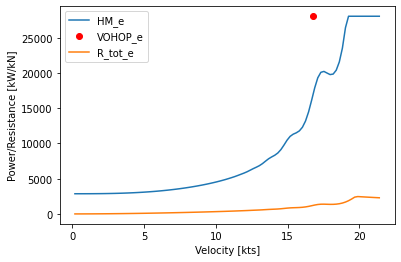

In [29]:
V_0 = np.linspace(0.1,11,100)
Power_e = np.zeros(len(V_0)) # Power empty
r_e = np.zeros(len(V_0)) # Resistance empty
for i in range(len(V_0)):
    Power_e[i]=calculate_power(V_0[i], T = 5.9, T_F = 3.29,BB='no')
    r_e[i] =(calculate_power(V_0[i],T=5.9,T_F = 3.29)-2863.6)/V_0[i] # vervangen in formules
print(Power_e.mean())
plt.plot(V_0 * 1.94384449,Power_e)
plt.plot(8.64 * 1.94384449,28064, 'ro')
plt.plot(V_0 * 1.94384449,r_e)
plt.legend(['HM_e', 'VOHOP_e','R_tot_e'])
plt.xlabel('Velocity [kts]')
plt.ylabel('Power/Resistance [kW/kN]')




In [6]:
class HasEnergyPlugin:
    """Mixin for Activity to initialize WeatherPluginActivity."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        energy_plugin = EnergyPlugin()
        self.register_plugin(plugin=energy_plugin, priority=3)


class EnergyPlugin(model.AbstractPluginClass):
    """Mixin for all activities to add delay and downtime."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def pre_process(self, env, activity_log, activity, *args, **kwargs 
    ):
        if activity.name == 'sailing empty':
#             activity.mover.compute_v = activity.mover.compute_vf
            if activity.mover.compute_ve(None) > activity.mover.V_max_e(None):
                activity.mover.compute_v = activity.mover.V_max_e
            else:
                activity.mover.compute_v = activity.mover.compute_ve
        else:
#              activity.mover.compute_v = activity.mover.compute_ve
            if activity.mover.compute_vf(None) > activity.mover.V_max_f(None):
                activity.mover.compute_v = activity.mover.V_max_f
            else:
                activity.mover.compute_v = activity.mover.compute_vf  
        return{}
    
    def post_process(
        self, env, activity_log, activity, start_activity, *args, **kwargs
    ):
        print('')
        print('post_process: {}, {}'.format(activity.mover.name,activity.name))
        
        if activity.name == 'sailing empty':
            if activity.mover.compute_ve(None) > activity.mover.V_max_e(None):
                V_0 = activity.mover.V_max_e(None)
            else:
                V_0 = activity.mover.compute_ve(None)
        else:
            if activity.mover.compute_vf(None) > activity.mover.V_max_f(None):
                V_0 = activity.mover.V_max_f(None)
            else:
                V_0 = activity.mover.compute_vf(None)

        
        
        if activity.name == "sailing empty":
            T = activity.mover.T_e
        else:
            T = activity.mover.T_f
            
        if activity.name == "sailing empty":
            T_F = activity.mover.T_Fe
        else:
            T_F = activity.mover.T_Ff
            
        self.power_empty = calculate_power(V_0=V_0,T=activity.mover.T_e, T_F = activity.mover.T_Fe)
        self.power_full = calculate_power(V_0=V_0, T=activity.mover.T_f, T_F = activity.mover.T_Ff)
        print('my T = {:.2f} m'.format(T))
        if activity.name == 'sailing empty':
            if self.power_empty > activity.mover.P_max:
                self.power_empty = activity.mover.P_max
            else:
                self.power_empty = self.power_empty
        else:
            if self.power_full > activity.mover.P_max:
                self.power_full = activity.mover.P_max
            else:
                self.power_full = self.power_full
        
        if activity.name == 'sailing empty':
            power = self.power_empty
        else:
            power = self.power_full
            
 
        print('my compute_v(None) is {} m/s'.format(activity.mover.compute_v(None))) #10
#         print('my compute_vf(None) is {} m/s'.format(activity.mover.compute_vf(None))) #8.7
       
        activity_duration = env.now - start_activity
        activity.log_entry(
            t=env.now,
            activity_id=activity.id,
            activity_state=core.LogState.UNKNOWN,
            additional_state={
                "power":power,
                "activity_duration":activity_duration,
                "energy_used":power*activity_duration/3600,
            }
        )
        
        return {}

#### 1. Initialise simpy environment

In [7]:
# setup environment (simulation time needs to match the available weather data)
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [8]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
        opentnsim.core.VesselProperties
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [9]:
# prepare input data for from_site 22.59603924999999
# 0.8983 = 100km
x1 = 0           # Coordinates in km
y1 = 0           # y-coordinates must remain 0!, adjust x-coordinates
x2 = 0.8983*18.52/100
y2 = 0

distance = (x2-x1)* 111.3213848    #km
location_from_site = shapely.geometry.Point(x1, y1)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 12,
                  "level": 12
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(x2, y2) #10 nm = 18.52 km
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 12,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)


##### 3.2. Create vessel object(s)

In [10]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 1,
                 "unloading_rate": 1,
                 "capacity": 4,
                 "compute_v": lambda x: 10,
                  "type":None,
                 "B":32,
                 "L":159,
                 "h_min":20,
                 "T":13.55,
                  
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
# Monkeypatch with L: Data from EIS HAM318
# Man Jiang case: 6 m waterdepth, M8 vessel at 4.0 m/s
vessel01.h = 70      # m waterdepth 
vessel01.L_wl = 159     # m length waterline 
vessel01.L_oa = 225       #m Lentgh overall
vessel01.B = 32    #m beam 
vessel01.T_e = 5.9 #m draft empty
vessel01.T_f = 13.55   #m draft full
vessel01.T_Fe = 3.29 #m forward draft
vessel01.T_Ff = 13.64 #m forward draft
vessel01.V_max_e = lambda x: 10.159   #m/s max velocity empty vessel
vessel01.V_max_f = lambda x: 9.604   #m/s max velocity full vessel
vessel01.compute_ve = lambda x: 10.0  # m/s
vessel01.compute_vf = lambda x: 9.5 # m/s


vessel01.ukc=4   # m under keel clearance
vessel01.P_max = 28064   # kW #check if time duration adjusts!! #If adjusting p_max -> use p2v to adjust v_max underneath 3 cells.

##### 3.3 Create activity/activities

In [11]:
# initialise registry
registry = {}
keep_resources = {}

In [12]:
# create delay sequence activities
DelaySequenceActivity =  type(
    "TestShiftActivity",
    (
        model.SequentialActivity,  # the order is critical!
    ),
    {},
)

DelayWhileActivity =  type(
    "TestShiftActivity",
    (
        model.WhileActivity,  # the order is critical!
    ),
    {},
)

DelayMoveActivity =  type(
    "TestMoveActivity",
    (
        HasEnergyPlugin,
        model.MoveActivity,  # the order is critical!
    ),
    {},
)

DelayShiftActivity =  type(
    "TestShiftActivity",
    (
        model.ShiftAmountActivity,  # the order is critical!
    ),
    {},
)

EnergyBasicActivity =  type(
    "TestShiftActivity",
    (
        model.BasicActivity,  # the order is critical!
    ),
    {},
)

In [13]:
# create a list of the sub processes
sub_processes = [
    DelayMoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    DelayShiftActivity(
        env=my_env,
        name="load cargo",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=3600,
    ),
    DelayMoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    DelayShiftActivity(
        env=my_env,
        name="unload cargo",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=3600,
    ),
    EnergyBasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = DelaySequenceActivity(
    env=my_env,
    name="Single run process",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while a stop condition is not met 
while_activity = DelayWhileActivity(
    env=my_env,
    name="While activity",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

In [14]:
# vessel01.__dict__

#### 4. Register processes and run simpy

In [15]:
model.register_processes([while_activity])
my_env.run()


post_process: vessel01, sailing empty
my T = 5.90 m
my compute_v(None) is 10.0 m/s

post_process: vessel01, sailing full
my T = 13.55 m
my compute_v(None) is 9.5 m/s

post_process: vessel01, sailing empty
my T = 5.90 m
my compute_v(None) is 10.0 m/s

post_process: vessel01, sailing full
my T = 13.55 m
my compute_v(None) is 9.5 m/s

post_process: vessel01, sailing empty
my T = 5.90 m
my compute_v(None) is 10.0 m/s

post_process: vessel01, sailing full
my T = 13.55 m
my compute_v(None) is 9.5 m/s


#### 5. Inspect results
##### 5.1 Inspect logs

In [16]:
df = pd.concat(
    [
        plot.get_log_dataframe(act, [while_activity, sequential_activity, *sub_processes])
        for act in sub_processes
    ]
).sort_values(by=['Timestamp'])
df

,Activity,Timestamp,ActivityState,power,activity_duration,energy_used
0,sailing empty,1970-01-01 00:00:00.000000,START,NaN,NaN,NaN
1,sailing empty,1970-01-01 00:00:00.000000,STOP,NaN,NaN,NaN
2,sailing empty,1970-01-01 00:00:00.000000,UNKNOWN,23777.113438,0.000000,0.000000
0,load cargo,1970-01-01 00:00:00.000000,START,NaN,NaN,NaN
0,sailing full,1970-01-01 01:00:00.000000,START,NaN,NaN,NaN
1,load cargo,1970-01-01 01:00:00.000000,STOP,NaN,NaN,NaN
0,unload cargo,1970-01-01 01:32:29.440515,START,NaN,NaN,NaN
1,sailing full,1970-01-01 01:32:29.440515,STOP,NaN,NaN,NaN
2,sailing full,1970-01-01 01:32:29.440515,UNKNOWN,26627.661359,1949.440515,14419.178302
0,Basic activity,1970-01-01 02:32:29.440515,START,NaN,NaN,NaN


In [17]:
df['energy_used'].sum()

67721.12649478325

##### 5.2 Visualise gantt charts

In [18]:
# objects = [while_activity, sequential_activity, vessel01, from_site, to_site]
# objects.extend(sub_processes)
# plot.get_gantt_chart(objects)

In [19]:
# # plotting just the vessel activities ()
# objects = [vessel01]
# objects.extend(sub_processes)
# plot.get_gantt_chart(objects)

# 6.1 Determine V based on Power

In [20]:
def power2v(vessel, h_min, bounds=(0, 210),P_max = 28064,T = 5.9, T_F = 3.29):
    """Compute vessel velocity given an edge and power (P_tot_given)
    
    bounds is the limits where to look for a solution for the velocity [m/s]
    returns velocity [m/s]
    """

    def seek_v_given_power(V_0 = V_0, vessel=vessel01, h_min=20,T = T, T_F = T_F):
        """function to optimize"""

       
        P_given = calculate_power(V_0 = V_0, T_F= T_F, T = T, h=70)
        if isinstance(P_given, complex):
            raise ValueError(f"P tot is complex: {P_given}")

        # compute difference between power setting by captain and power needed for velocity
        diff = P_max - P_given

        return diff ** 2

    # fill in some of the parameters that we already know
    fun = functools.partial(seek_v_given_power, vessel=vessel, h_min = h_min)
    # lookup a minimum
    fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')
#     print(fun)
    # check if we found a minimum
    if not fit.success:
        raise ValueError(fit)
    return fit.x


# Insert Cell to determine V

In [26]:
power2v(vessel=vessel01, h_min=20, bounds=(0, 10.159),T = 5.9, T_F = 3.29,P_max = 256064) # use this cell to determine speed at a certain power
# Next adjust compute_ve/vf in upper cells to adjust the power and duration needed for the project

10.158332083085703

# 6.1 Acceleration and Deceleration (given P)

Text(0, 0.5, 'Power')

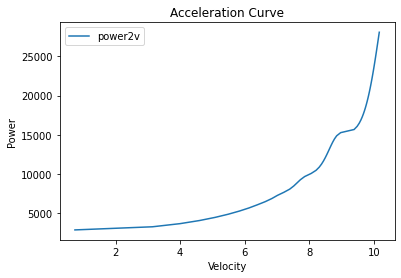

In [22]:
# Before use change Draft values in above function (empty or full)
P = np.linspace(2870,28064,64) # Power
v = np.zeros(len(P))
for i in range(len(P)):
    v[i] = power2v(vessel01,h_min=20,bounds=(0,10.2), T=5.9, T_F= 3.29,P_max=P[i])
#     print(v[i])
plt.plot(v,P)
plt.legend(['power2v'])
plt.title('Acceleration Curve')
plt.xlabel('Velocity')
plt.ylabel('Power')

high
10.159
Power consumption during acc/dec = 7012.96 kW
Power consumption during free sailing = 28064.00 kW
Energy consumption during acceleration = 35622.33 kWh
Energy consumption during deceleration = 71244.66 kWh


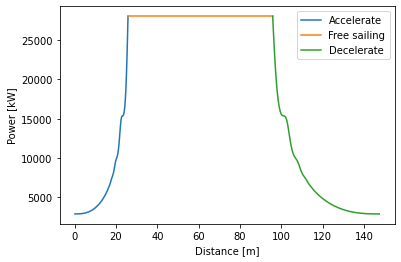

In [45]:
x1 = 0   # startpoint m 77.40396075000001
x2 = 147.40396075000001 # endpoint m

distance = (x2-x1)    #m

def t_acc(s_tot = distance, a_acc = 2, a_dec = 1, s_free = 0):
    
    if distance < (vessel01.V_max_e(None)/a_dec)**2*0.5*((a_dec**2/a_acc) + a_dec):
        t_d = np.sqrt(distance/(0.5 * ((a_dec**2/a_acc) + a_dec)))
        s_free = 0
        t_a = (a_dec * t_d)/a_acc
        va = a_acc * t_a
        vd = a_dec * t_d
        s_d = 0.5 * a_dec * t_d**2
        s_a = 0.5 * a_acc * t_a**2
        s_tot = s_a + s_d + s_free
        print('low')
        V_0 = np.linspace(0.1,va,100)
        S_0 = np.linspace(0.1,s_a,100)
        S_1 = np.linspace(s_tot,s_a,100)
        Power_ea = np.zeros(len(V_0)) # Power empty
        Power_ed = np.zeros(len(V_0))
        for i in range(len(V_0)):
            Power_ea[i]=calculate_power(V_0[i], T = 5.9, T_F = 3.29)
            Power_ed[i] = calculate_power(V_0[i], T = 5.9, T_F = 3.29)
        plt.plot(S_0,Power_ea) #Power empty acceleration
        plt.plot(S_1,Power_ed) # Power empty deceleration
        plt.legend(['Accelerate', 'Decelerate'])
        plt.xlabel('Distance [m]')
        plt.ylabel('Power [kW]')
        energy_a = t_a * Power_ea.mean()
        energy_d = t_d * Power_ed.mean()
        print('Power consumption during acc/dec = {:.2f} kW'.format(Power_ea.mean()))
        print('energy consumption during acceleration = {:.2f} kWh'.format(energy_a))
        print('energy consumption during deceleration = {:.2f} kWh'.format(energy_d))
    elif distance == (vessel01.V_max_e(None)/a_dec)**2*0.5*((a_dec**2/a_acc) + a_dec):
        s_free = 0
        t_d = np.sqrt((s_tot-s_free)/(0.5 * ((a_dec**2/a_acc) + a_dec)))
        t_a = (a_dec * t_d)/a_acc
        print('middle')
        va = a_acc * t_a
        vd = a_dec * t_d
        s_a = 0.5 * a_acc * t_a**2
        s_d = 0.5 * a_dec * t_d**2
        s_tot = s_a + s_d + s_free
        V_0 = np.linspace(0.1,va,100)
        S_0 = np.linspace(0.1,s_a,100)
        S_1 = np.linspace(s_tot,s_a,100)
        Power_e = np.zeros(len(V_0)) # Power empty
        for i in range(len(V_0)):
            Power_e[i]=calculate_power(V_0[i], T = 5.9, T_F = 3.29)
        plt.plot(S_0,Power_e)
        plt.plot(S_1,Power_e)
#         plt.plot(8.64,28064, 'ro')
        plt.legend(['Accelerate', 'Decelerate'])
        plt.xlabel('Distance [m]')
        plt.ylabel('Power [kW]')
        energy_a = t_a * Power_e.mean()
        energy_d = t_d * Power_e.mean()
        print('Power consumption during acc/dec = {:.2f} kW'.format(Power_e.mean()))
        print('energy consumption during acceleration = {:.2f} kWh'.format(energy_a))
        print('energy consumption during deceleration = {:.2f} kWh'.format(energy_d))
    elif distance > (vessel01.V_max_e(None)/a_dec)**2*0.5*((a_dec**2/a_acc) + a_dec):
        s_free = s_tot - (vessel01.V_max_e(None)/a_dec)**2*0.5*((a_dec**2/a_acc) + a_dec)
        print('high')
        t_d = np.sqrt(((vessel01.V_max_e(None)/a_dec)**2*0.5*((a_dec**2/a_acc) + a_dec))/(0.5 * ((a_dec**2/a_acc) + a_dec)))
        t_a = (a_dec * t_d)/a_acc
        va = a_acc * t_a
        vd = a_dec * t_d
        s_d = 0.5 * a_dec * t_d**2
        s_a = 0.5 * a_acc * t_a**2
        s_tot = s_a + s_d + s_free
        print(va)
        t_free = s_free/va
        V_0 = np.linspace(0.1,va,100)
        S_1 = np.linspace(0.1,s_a,100)
        S_2 = np.linspace(s_a+s_free,s_a,100)
        S_3 = np.linspace(s_tot,s_a+s_free,100)
        Power_e = np.zeros(len(V_0)) # Power empty
        Power_max = np.ones(len(V_0)) * vessel01.P_max
        for i in range(len(V_0)):
            Power_e[i]=calculate_power(V_0[i], T = 5.9, T_F = 3.29)
        plt.plot(S_1,Power_e)
        plt.plot(S_2,Power_max)
        plt.plot(S_3,Power_e)
#         plt.plot(8.64,28064, 'ro')
        plt.legend(['Accelerate', 'Free sailing', 'Decelerate'])
        plt.xlabel('Distance [m]')
        plt.ylabel('Power [kW]')
        energy_a = t_a * Power_e.mean()
        energy_d = t_d * Power_e.mean()
#         energy_free = calculate_power(V_0=v, T = 5.9, T_F = 3.29) * t_free
        print('Power consumption during acc/dec = {:.2f} kW'.format(Power_e.mean()))
        print('Power consumption during free sailing = {:.2f} kW'.format(Power_max.mean()))
        print('Energy consumption during acceleration = {:.2f} kWh'.format(energy_a))
        print('Energy consumption during deceleration = {:.2f} kWh'.format(energy_d))
#         print('Power consumption during free sailing = {:.2f} kW'.format(calculate_power(V_0=v, T = 5.9, T_F = 3.29)))
#         print('energy consumption during free sailing = {:.2f} kWh'.format(energy_free))
    return
t_acc()


In [24]:
def cp(V_0=9, h=70,
L_wl=159, B=32, T = 13.55, T_e=5.9, T_Fe = 3.29, T_Ff = 13.64, T_F = 13.55,nu=0.000001, C_b=0.85, rho=1025,
c_stern = 0, one_k2=2.5, g=9.81, P_inst = 28636, P_max = 28064, V_max_e = 8.925, V_max_f = 8.079, BB = 'yes'):  
    #########################################################################################################################
    
    
    
    """1) Frictional resistance
            - 1st resistance component defined by Holtrop and Mennen (1982)
            - A modification to the original friction line is applied, based on literature of Zeng (2018), to account for 
            shallow water 
            effects """
    C_M = 1.006 - 0.0056 * C_b ** (-3.56)  # Midship section coefficient: ratio of actual area of immersed portion of the 
#                                            ships midship section to the porduct of wdht and draft.
    C_wp = (1 + 2 * C_b) / 3  # Waterplane coefficient : ratio of the actual area of the waterplane 
#                               to the product of the length and breadth of ship.
    C_p = C_b / C_M  # Prismatic coefficient: ratio of volume of displacement of a ship to that of a prism
#                       equal to lentg to tge distance between perpendicualrs of the ship and in cross-section of that of the 
#immersed midship section.
    C_BB = 0.2 #coefficient related to the width of the bulbous bow and the width of the ship.
    
    
    # Block coefficient Cb = ratio underwater volume of ship to volume of recatngle having same overall length, breadth 
    #and depth.
    delta = C_b * L_wl * B * T  # Water displacement

    lcb = -13.5 + 19.4 * C_p  # longitudinal center of buoyancy
    L_R = L_wl * (1 - C_p + (0.06 * C_p * lcb) / (
                4 * C_p - 1))  # parameter reflecting the length of the run

    A_T = 0.2 * B * T  # transverse area of the transom
    
    if BB == "yes": #yes if vessel has a bulbous bow
        A_BT = C_BB * B * T * C_M # transverse area of the bulb
    else:
        A_BT = 0
   
    # Total wet area
    S_T = L_wl * (2 * T + B) * np.sqrt(C_M) * (
                0.453 + 0.4425 * C_b - 0.2862 * C_M - 0.003467 * (
                    B / T) + 0.3696 * C_wp) + 2.38 * (A_BT / C_b)

    S_APP = 0.1 * S_T  # Wet area of appendages
    S_B = L_wl * B  # Area of flat bottom

    D_s = 0.7 * T  # Diameter of the screw


    R_e = V_0 * L_wl / nu  # Reynolds number
    D = h - T  # distance from bottom ship to the bottom of the fairway
    def rf(V_0 = V_0):
        
        # Friction coefficient in deep water
        Cf_0 = 0.075 / ((np.log10(R_e) - 2) ** 2)

        # Friction coefficient proposed, taking into account shallow water effects
        Cf_proposed = (0.08169 / ((np.log10(R_e) - 1.717) ** 2)) * (
                    1 + (0.003998 / (np.log10(R_e) - 4.393)) * (D / L_wl) ** (-1.083))

        # 'a' is the coefficient needed to calculate the Katsui friction coefficient
        a = 0.042612 * np.log10(R_e) + 0.56725
        Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762) ** a)

        # The average velocity underneath the ship, taking into account the shallow water effect

        if h / T <= 4:
            V_B = 0.4277 * V_0 * np.exp((h / T) ** (-0.07625))
        else:
            V_B = V_0

        # cf_proposed cannot be applied directly, since a vessel also has non-horizontal wet surfaces that have to be taken
        # into account. Therefore, the following formula for the final friction coefficient 'C_f' is defined:
        C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0) ** 2

        # The total frictional resistance R_f [kN]:
        R_f = (C_f * 0.5 * rho * (V_0 ** 2) * S_T) / 1000
        return R_f

    ########################################################################################################################

    """2) Viscous resistance
    - 2nd resistance component defined by Holtrop and Mennen (1982)
    - Form factor (1 + k1) has to be multiplied by the frictional resistance R_f, to account for the effect of viscosity"""
    def k1(V_0=V_0):
        
        # c_14 accounts for the specific shape of the afterbody
        c_14 = 1 + 0.0011 * c_stern

        # the form factor (1+k1) describes the viscous resistance
        one_k1 = 0.93 + 0.487118 * c_14 * ((B / L_wl) ** 1.06806) * ((T / L_wl) ** 0.46106) * (
                    (L_wl / L_R) ** 0.121563) * (((L_wl ** 3) / delta) ** 0.36486) * (
                                  (1 - C_p) ** (-0.60247))
        return one_k1

    ########################################################################################################################


    """3) Appendage resistance
    - 3rd resistance component defined by Holtrop and Mennen (1982)
    - Appendages (like a rudder, shafts, skeg) result in additional frictional resistance"""

    # Frictional resistance resulting from wetted area of appendages: R_APP [kN]
    def rapp(V_0 = V_0):
        Cf_0 = 0.075 / ((np.log10(R_e) - 2) ** 2)

        # Friction coefficient proposed, taking into account shallow water effects
        Cf_proposed = (0.08169 / ((np.log10(R_e) - 1.717) ** 2)) * (
                    1 + (0.003998 / (np.log10(R_e) - 4.393)) * (D / L_wl) ** (-1.083))

        # 'a' is the coefficient needed to calculate the Katsui friction coefficient
        a = 0.042612 * np.log10(R_e) + 0.56725
        Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762) ** a)

        # The average velocity underneath the ship, taking into account the shallow water effect

        if h / T <= 4:
            V_B = 0.4277 * V_0 * np.exp((h / T) ** (-0.07625))
        else:
            V_B = V_0

        # cf_proposed cannot be applied directly, since a vessel also has non-horizontal wet surfaces that have to be taken
        # into account. Therefore, the following formula for the final friction coefficient 'C_f' is defined:
        C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0) ** 2
        R_APP = (0.5 * rho * (V_0 ** 2) * S_APP * one_k2 * C_f) / 1000
        return R_APP
    #################################################################################################################


    """Intermediate calculation: Karpov
    - The Karpov method computes a velocity correction that accounts for limited water depth (corrected velocity V2)
    - V2 has to be implemented in the wave resistance and the residual resistance terms"""

# The Froude number used in the Karpov method is the depth related froude number F_nh

# The different alpha** curves are determined with a sixth power polynomial approximation in Excel
# A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve

    F_nh = V_0 / np.sqrt(g * h)

    if F_nh <= 0.4:

        if 0 <= h / T < 1.75:
            alpha_xx = (-4 * 10 ** (
                -12)) * F_nh ** 3 - 0.2143 * F_nh ** 2 - 0.0643 * F_nh + 0.9997
        if 1.75 <= h / T < 2.25:
            alpha_xx = -0.8333 * F_nh ** 3 + 0.25 * F_nh ** 2 - 0.0167 * F_nh + 1
        if 2.25 <= h / T < 2.75:
            alpha_xx = -1.25 * F_nh ** 4 + 0.5833 * F_nh ** 3 - 0.0375 * F_nh ** 2 - 0.0108 * F_nh + 1
        if h / T >= 2.75:
            alpha_xx = 1

    if F_nh > 0.4:
        if 0 <= h / T < 1.75:
            alpha_xx = -0.9274 * F_nh ** 6 + 9.5953 * F_nh ** 5 - 37.197 * F_nh ** 4 + 69.666 * F_nh ** 3 - 65.391 * F_nh ** 2 + 28.025 * F_nh - 3.4143
        if 1.75 <= h / T < 2.25:
            alpha_xx = 2.2152 * F_nh ** 6 - 11.852 * F_nh ** 5 + 21.499 * F_nh ** 4 - 12.174 * F_nh ** 3 - 4.7873 * F_nh ** 2 + 5.8662 * F_nh - 0.2652
        if 2.25 <= h / T < 2.75:
            alpha_xx = 1.2205 * F_nh ** 6 - 5.4999 * F_nh ** 5 + 5.7966 * F_nh ** 4 + 6.6491 * F_nh ** 3 - 16.123 * F_nh ** 2 + 9.2016 * F_nh - 0.6342
        if 2.75 <= h / T < 3.25:
            alpha_xx = -0.4085 * F_nh ** 6 + 4.534 * F_nh ** 5 - 18.443 * F_nh ** 4 + 35.744 * F_nh ** 3 - 34.381 * F_nh ** 2 + 15.042 * F_nh - 1.3807
        if 3.25 <= h / T < 3.75:
            alpha_xx = 0.4078 * F_nh ** 6 - 0.919 * F_nh ** 5 - 3.8292 * F_nh ** 4 + 15.738 * F_nh ** 3 - 19.766 * F_nh ** 2 + 9.7466 * F_nh - 0.6409
        if 3.75 <= h / T < 4.5:
            alpha_xx = 0.3067 * F_nh ** 6 - 0.3404 * F_nh ** 5 - 5.0511 * F_nh ** 4 + 16.892 * F_nh ** 3 - 20.265 * F_nh ** 2 + 9.9002 * F_nh - 0.6712
        if 4.5 <= h / T < 5.5:
            alpha_xx = 0.3212 * F_nh ** 6 - 0.3559 * F_nh ** 5 - 5.1056 * 4 + 16.926 * F_nh ** 3 - 20.253 * F_nh ** 2 + 10.013 * F_nh - 0.7196
        if 5.5 <= h / T < 6.5:
            alpha_xx = 0.9252 * F_nh ** 6 - 4.2574 * F_nh ** 5 + 5.0363 * F_nh ** 4 + 3.3282 * F_nh ** 3 - 10.367 * F_nh ** 2 + 6.3993 * F_nh - 0.2074
        if 6.5 <= h / T < 7.5:
            alpha_xx = 0.8442 * F_nh ** 6 - 4.0261 * F_nh ** 5 + 5.313 * F_nh ** 4 + 1.6442 * F_nh ** 3 - 8.1848 * F_nh ** 2 + 5.3209 * F_nh - 0.0267
        if 7.5 <= h / T < 8.5:
            alpha_xx = 0.1211 * F_nh ** 6 + 0.628 * F_nh ** 5 - 6.5106 * F_nh ** 4 + 16.7 * F_nh ** 3 - 18.267 * F_nh ** 2 + 8.7077 * F_nh - 0.4745

        if 8.5 <= h / T < 9.5:
            if F_nh < 0.6:
                alpha_xx = 1
            if F_nh >= 0.6:
                alpha_xx = -6.4069 * F_nh ** 6 + 47.308 * F_nh ** 5 - 141.93 * F_nh ** 4 + 220.23 * F_nh ** 3 - 185.05 * F_nh ** 2 + 79.25 * F_nh - 12.484
        if h / T >= 9.5:
            if F_nh < 0.6:
                alpha_xx = 1
            if F_nh >= 0.6:
                alpha_xx = -6.0727 * F_nh ** 6 + 44.97 * F_nh ** 5 - 135.21 * F_nh ** 4 + 210.13 * F_nh ** 3 - 176.72 * F_nh ** 2 + 75.728 * F_nh - 11.893

    V_2 = V_0 / alpha_xx

    #################################################################################################################


    """4) Wave resistance
    - 4th resistance component defined by Holtrop and Mennen (1982)
    - When the speed or the vessel size increases, the wave making resistance increases
    - In shallow water, the wave resistance shows an asymptotical behaviour by reaching the critical speed"""

    # parameters
    h_B = 0.2 * T_F    #Position of the centre of the transverse area [m]

    


    """Wave resistance
    - 4th resistance component defined by Holtrop and Mennen (1982)
    - When the speed or the vessel size increases, the wave making resistance increases
    - In shallow water, the wave resistance shows an asymptotical behaviour by reaching the critical speed
    """

    assert g >= 0, f'g should be positive: {g}'
    assert L_wl >= 0, f'L should be positive: {L_wl}'
    
    def rw(V_2=V_2):
        F_rL = V_2 / np.sqrt(g * L_wl)  # Froude number based on ship's speed to water and its length of waterline

        # parameter c_7 is determined by the B/L ratio
        if B / L_wl < 0.11:
            c_7 = 0.229577 * (B / L_wl) ** 0.33333
        if B / L_wl > 0.25:
            c_7 = 0.5 - 0.0625 * (L_wl / B)
        else:
            c_7 = B / L_wl

        # half angle of entrance in degrees
        i_E = 1 + 89 * np.exp(-((L_wl / B) ** 0.80856) * ((1 - C_wp) ** 0.30484) * (
                    (1 - C_p - 0.0225 * lcb) ** 0.6367) * ((L_R / B) ** 0.34574) * (
                                               (100 * delta / (L_wl ** 3)) ** 0.16302))

        c_1 = 2223105 * (c_7 ** 3.78613) * ((T / B) ** 1.07961) * (90 - i_E) ** (-1.37165)
        c_3 = (0.56 * A_BT**1.5)/(B * T *(0.31 * np.sqrt(A_BT)+T_F - h_B))
        if BB == 'yes':
            c_2 = np.exp(-1.89 * np.sqrt(c_3))
        else:
            c_2 = 1      # accounts for the effect of the bulbous bow, which is not present at inland ships
        c_5 = 1 - (0.8 * A_T) / (
                    B * T * C_M)  # influence of the transom stern on the wave resistance

        # parameter c_15 depoends on the ratio L^3 / delta
        if (L_wl ** 3) / delta < 512:
            c_15 = -1.69385
        if (L_wl ** 3) / delta > 1727:
            c_15 = 0
        else:
            c_15 = -1.69385 + (L_wl / (delta ** (1 / 3)) - 8) / 2.36

        # parameter c_16 depends on C_P
        if C_p < 0.8:
            c_16 = 8.07981 * C_p - 13.8673 * (C_p ** 2) + 6.984388 * (C_p ** 3)
        else:
            c_16 = 1.73014 - 0.7067 * C_p

        if L_wl / B < 12:
            lmbda = 1.446 * C_p - 0.03 * (L_wl / B)
        else:
            lmbda = 1.446 * C_p - 0.36

        m_1 = 0.0140407 * (L_wl / T) - 1.75254 * ((delta) ** (1 / 3) / L_wl) - 4.79323 * (
                    B / L_wl) - c_16
        m_2 = c_15 * (C_p**2) *np.exp((-0.1)* (F_rL**(-2))) 

        R_W = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_rL**(-0.9)) + 
                   m_2 * np.cos(lmbda * (F_rL ** (-2)))) / 1000 # kN
        return R_W

   

    #################################################################################################################

    """5) Bulbous Bow Resistance terms
    - Extra resistance due to bulbousbow. Not for IWT, Yes for Dredging Vessels"""
    # Only include Rb if bulbous bow is present, so make if statement
    # R_B
   
    def rb(V_2=V_2):
    
    # Froude number based on immersoin of bulbous bow [-]
        F_ni = (V_2/np.sqrt(g*(T_F - h_B - 0.25*np.sqrt(A_BT)+0.15*V_2**2)))

        #P_B is coefficient for the emergence of bulbous bow
        P_B = (0.56 * np.sqrt(A_BT))/(T_F - 1.5*h_B)

        if BB == "yes":
            R_B = ((0.11 * np.exp(-3* P_B**2) * F_ni**3 * A_BT**1.5 * rho * g)/(1+ F_ni**2)) /1000
        else:
            R_B = 0
        return R_B
    #################################################################################################################
    """6) Residual resistance terms
    - Holtrop and Mennen (1982) defined three residual resistance terms:
    - 1) Resistance due to the bulbous bow (not incorporated since inland ships in general don't have a bulb)
    - 2) Resistance due to immersed transom
    - 3) Resistance due to model-ship correlation """

    # Resistance due to immersed transom: R_TR [kN]
    
    def rtr(V_2=V_2):
        F_nt = V_2 / np.sqrt(
            2 * g * A_T / (B + B * C_wp))  # Froude number based on transom immersion

        if F_nt < 5:
            c_6 = 0.2 * (1- 0.2 * F_nt) # coefficient related to the Froude number and the transom immersion
        else:
            c_6 = 0


        R_TR = (0.5 * rho * (V_2 ** 2) * A_T * c_6) / 1000
        return R_TR

    # Model-ship correlation resistance: R_A [kN]
    def ra(V_2=V_2):
        
        if T / L_wl < 0.04:
            c_4 = T / L_wl
        else:
            c_4 = 0.04
        c_2 = 1

        C_A = 0.006 * (L_wl + 100) ** (-0.16) - 0.00205 + 0.003 * np.sqrt(L_wl / 7.5) * (
                    C_b ** 4) * c_2 * (0.04 - c_4)

        ####### Holtrop and Mennen in the document of Sarris, 2003 #######
        R_A = (0.5 * rho * (V_2 ** 2) * S_T * C_A) / 1000  # kW
        return R_A
    

    #################################################################################################################
    def rtot(V_0=V_0):
        R_tot = rf()*k1() + rapp() + rw() + rb() + rtr() + ra()
        return R_tot
    
    P_prop = rtot() * V_0
    P_board = 0.1 * P_inst # 10 percent for dredging vessels
    print('my total resistance = {:.2f} kN'.format(rtot(V_0=V_0)))
    if P_prop+P_board > P_max:
        P_tot = P_max
    else:
        P_tot = P_prop + P_board
        
        
#     fric = ((rf() * one_k1) + rapp()) / R_tot
#     wave = R_W / R_tot
#     press = (R_B + R_TR + R_A)/R_tot
    
    

#     print('my total resistance = {:.2f} kN'.format(R_tot))
    speed = np.linspace(0.1,8.925,100)
    frictional = np.zeros(len(speed))
    viscous = np.zeros(len(speed))
    wave = np.zeros(len(speed))
    appendage = np.zeros(len(speed))
    transom = np.zeros(len(speed))
    bow = np.zeros(len(speed))
    addition = np.zeros(len(speed))
    total = np.zeros(len(speed))
    
    for i in range(len(speed)):
        frictional[i] = rf(V_0 = speed[i])
        viscous[i] = k1(V_0 = speed[i])
        wave[i] = rw(V_2 = speed[i])
        appendage[i] = rapp(V_0 = speed[i])
        transom[i] = rtr(V_2 = speed[i])
        bow[i] = rb(V_2 = speed[i])
        addition[i] = ra(V_2 = speed[i])
        total[i] = rf(V_0 = speed[i])*k1(V_0 = speed[i])+rw(V_2 = speed[i])+rapp(V_0 = speed[i])+rtr(V_2 = speed[i])+rb(V_2 = speed[i])+ra(V_2 = speed[i])
        

    plt.plot(speed*1.94384449,((frictional*viscous)+appendage)/total*100)
    plt.plot(speed*1.94384449,wave/total*100)
    plt.plot(speed*1.94384449, (transom + bow + addition)/total*100)
    plt.legend(['Friction', 'Wave', 'Pressure', 'Total'])
    plt.ylabel('Percentages [%]')
    plt.xlabel('Velocity [kts]')
    return P_tot

my total resistance = 2498.12 kN


25346.68498141982

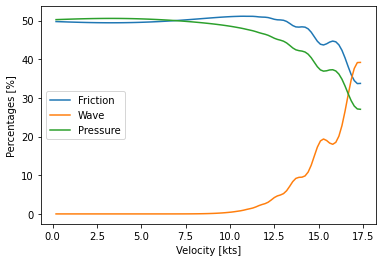

In [25]:
cp()